# Fast Adaptive Broadening

Convolution is a common operation used for broadening spectral data, where a kernel (often either a Gaussian or Lorentzian) is used to broaden the data. Convolution with a fixed kernel can be carried out efficiently using Fast Fourier Transforms (FFTs). However, when simulating Inelastic Neutron Scattering (INS) spectra, the width of the Gaussian kernel used for broadening is variable, and therefore performing convolution by a fixed kernel is not appropriate. Instead, an adaptive broadening technique is required.

Adaptive broadening can be implemented exactly by computing a Gaussian kernel for each point along the input spectrum, where the standard deviation, $\sigma$, of each kernel is dependent on its associated input data point. The sum of the product of each kernel and its associated data point should then be calculated to give the broadened spectrum. Whilst this approach provides accurate results, the evaluation of N Gaussian Functions (where N is the number of convolution bins) is computationally expensive, leading to a poor user experience.

To reduce computation time, a faster, approximate method is required. This can be achieved by reducing the number of Gaussian functions that have to be evaluated. Taking the range of $\sigma$ values for the spectrum, a Gaussian function need only be evaluated for regularly spaced $\sigma$ values across this range. The kernels at intermediate $\sigma$ values can then be approximated using a weighted linear combination of the two closest kernels that have been calculated exactly. The weights for the linear combination can be determined, for example, using linear interpolation, where the weight $w = (\sigma - \sigma_{min})/(\sigma_{max} - \sigma_{min})$ can be used to approximate the Gaussian $G(x;\sigma) = (1-w)G(x;\sigma_{min}) + wG(x;\sigma_{max})$. For more detail on the linear combination weights and how they can be optimized, please see the [Approximating Gaussians](gaussian_approximation.ipynb) notebook.

The values of $\sigma$ for which the Gaussian function is evaluated exactly should be regularly spaced over the range of $\sigma$ values, with the spacing denoted as the width factor. With regular spacing, the relationship between the weights will be the same between each set of exact kernels. This relationship is determined by computing weights between a Gaussian with $\sigma=1$ and a Gaussian with $\sigma$ equal to the width factor. For instance, consider a width factor of 2 has been selected - the plot below shows the relationship between the weight, $w$, when it is determined using linear interpolation. A polynomial can then be fitted (in this case a 1st order polynomial as linear interpolation has been used), allowing weights to be determined for any $\sigma$ value in that range.

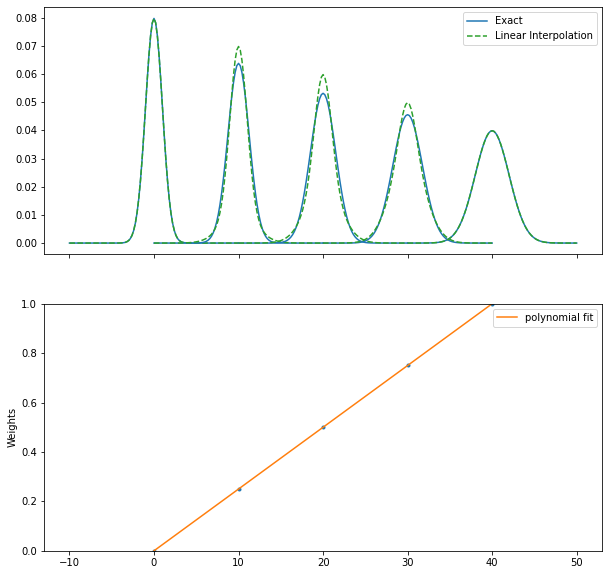

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 10]

def gaussian(x, sigma=2, center=0):
    g = np.exp(-0.5 * ((x - center) / sigma)**2) / (sigma * np.sqrt(2 * np.pi))
    return g*0.2

def legend_without_duplicate_labels(ax):
            handles, labels = ax.get_legend_handles_labels()
            unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
            ax.legend(*zip(*unique))

def plot_linear_interp():
    """Plot linearly-interpolated Gaussians"""

    g1_center = 0
    g2_center = 40
    sigma_max = 2
    sigma_min = 1

    mix_list=[]

    x = np.linspace(-10, 10, 101)
    npts = 5

    fig, [ax1, ax2] = plt.subplots(nrows=2,
                                   sharex=True,
                                   gridspec_kw={
                                   'height_ratios': [1, 1]})

    for sigma in np.linspace(sigma_min, sigma_max, npts):
        x_offset = (g1_center
                  + ((sigma - sigma_min)
                     * (g2_center - g1_center) / (sigma_max - sigma_min)))
        actual = gaussian(x, sigma=sigma)
        low_ref = gaussian(x, sigma=sigma_min)
        high_ref = gaussian(x, sigma=sigma_max)
        mix = (sigma - sigma_min) / (sigma_max - sigma_min)
        est = (1 - mix) * low_ref + mix * high_ref
        ax1.plot(x + x_offset, actual, color='C0', label='Exact')
        ax1.plot(x + x_offset, est, c='C2', linestyle='--',  label='Linear Interpolation')
        legend_without_duplicate_labels(ax1)

        mix_list.append(mix)
    
    ax2.plot(np.linspace(g1_center, g2_center, npts), mix_list, '.')
    ax2.set_ylabel('Weights')
    ax2.set_ylim([0, 1])

    m, b = np.polyfit(np.linspace(g1_center, g2_center, npts), mix_list, 1)
    ax2.plot(np.linspace(g1_center, g2_center, npts), m*np.linspace(g1_center, g2_center, npts)+b,label='polynomial fit')
    ax2.legend()

plot_linear_interp()

Using the properties of convolution, these same weights can be used to scale the unbroadened spectrum, splitting the data into $\sigma_{min}$ and $\sigma_{max}$ contributions which can then be convolved using the $\sigma_{min}$ and $\sigma_{max}$ kernels respectively. The two broadened spectra can then be added together and this is equivalent to convolving the unbroadened spectrum with the linear combination of the two Gaussian functions, as shown below. 

$$
\begin{align}
f*((1-w)G_1 + w G_2) &= \int^{\infty}_{-\infty} f(\tau)((1-w)G_1(t-\tau)) + f(\tau)(w G_2(t-\tau)) \delta\tau \\
                    &=  \int^{\infty}_{-\infty} ((1-w)f(\tau)) G_1(t-\tau) \delta\tau + \int^{\infty}_{-\infty} (w f(\tau))G_2(t-\tau) \delta\tau\\
                    &= ((1-w)f)*G_1 + (wf)*G_2
\end{align}
$$

With this approach, each convolution has a fixed width kernel, therefore it can be performed efficiently using FFTs (which reduces complexity from $O(N^2)$ to $O(NlogN)$). This method does also require that data is binned before convolution which will introduce quantization error. These steps are illustrated below:

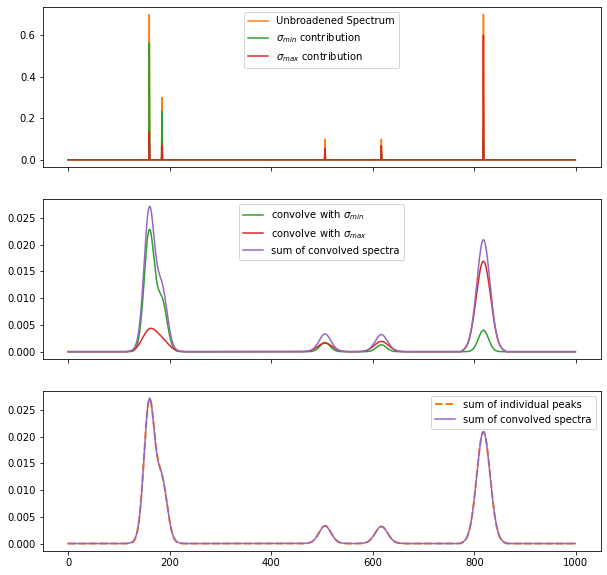

In [2]:
from scipy.signal import convolve
from scipy.optimize import curve_fit

npts = 1000
y = np.zeros(npts)

y[160] = 0.7
y[185] = 0.3
y[506] = 0.1
y[617] = 0.1
y[818] = 0.7

bins = np.linspace(0,100,1001)
bin_mp = (bins[1:]+bins[:-1])/2
frequencies = bin_mp

sigma_min=1

def broaden_sigma_range(sigma_max):

    fig, [ax1, ax2, ax3] = plt.subplots(nrows=3,
                                    sharex=True,
                                    gridspec_kw={
                                    'height_ratios': [1, 1, 1]})

    ax1.plot(range(0,npts), y, 'C1', label='Unbroadened Spectrum')

    sigma = np.linspace(1, sigma_max, 1000)

    def gaussian_eval(sigma, points, center):
        # calculate bin width, which is then used to normalize the Gaussian
        b_width = points[1] - points[0] 
        kernel = np.exp(-(points - center)**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))*b_width
        return kernel

    def gaussian_mix(x, w1):
        #Return a linear combination of two Gaussians with weights
        return (w1 * gaussian(x, sigma=sigma_min)
                + (1-w1) * gaussian(x, sigma=sigma_max))

    def find_coeffs(sigma_max):
        sigma_values = np.linspace(sigma_min, sigma_max, 10)
        x = np.linspace(-10, 50, 101)

        lower_mix = np.zeros(len(sigma_values))

        for i, sigma in enumerate(sigma_values):
            actual_gaussian = gaussian(x, sigma)
            mixl, _ = curve_fit(gaussian_mix, x, ydata=actual_gaussian, p0=[0.5],bounds=(0,1))

            mixl=mixl[0]
            lower_mix[i] = mixl

        coeffs = np.polyfit(sigma_values, lower_mix,3)
        return coeffs

    lower_coeffs = find_coeffs(sigma_max)

    # reference method
    kernels = gaussian_eval(sigma[:,np.newaxis], bin_mp, frequencies[:,np.newaxis])
    result_gauss = np.dot(kernels.transpose(), y)

    bin_width = bins[1]-bins[0]

    # fast method
    sigma_samples = np.array([1,sigma_max])
    sigma_range = np.ceil(3*sigma_max/bin_width)
    kernels = gaussian_eval(sigma=sigma_samples[:, np.newaxis],
                            points=np.arange(-sigma_range, sigma_range+1, 1)*bin_width, center=0)

    lower_mix = np.polyval(lower_coeffs, sigma)
    upper_mix = 1-lower_mix

    lower_scaled = lower_mix*y
    ax1.plot(lower_scaled, 'C2', label='$\sigma_{min}$ contribution')

    upper_scaled = upper_mix*y
    ax1.plot(upper_scaled, 'C3', label='$\sigma_{max}$ contribution')
    ax1.legend()

    lower_convolve = convolve(lower_scaled, kernels[0], mode="same")
    upper_convolve = convolve(upper_scaled, kernels[1], mode="same")

    spectrum = lower_convolve+upper_convolve

    ax2.plot(range(0,len(y)), lower_convolve, 'C2', label='convolve with $\sigma_{min}$')
    ax2.plot(range(0,len(y)), upper_convolve, 'C3', label='convolve with $\sigma_{max}$')
    ax2.plot(range(0,len(y)), spectrum, 'C4', label='sum of convolved spectra')
    ax2.legend()

    ax3.plot(result_gauss,'--', linewidth=2, color='C1', label='sum of individual peaks')
    ax3.plot(spectrum, 'C4', label='sum of convolved spectra')
    ax3.legend()

broaden_sigma_range(np.sqrt(2))

The top plot shows an unbroadened spectrum where $\sigma_{min}=1$ at $x=0$ and $\sigma_{max}=\sqrt{2}$ at $x=100$. The spectrum has been broken down into two components, using the linear combination weights (determined by optimised interpolation) used to approximate a Gaussian at each sigma value between $\sigma_{min}$ and $\sigma_{max}$.

The middle plot shows the $\sigma_{min}$ and $\sigma_{max}$ contribution spectra convolved with Gaussian kernels of width $\sigma_{min}$ and $\sigma_{max}$ respectively. Also shown is the sum of the two convolved spectra. The bottom plot shows the resulting adaptively broadened spectrum produced using both the exact implementation where a Gaussian kernel is evaluated for each input point, and the faster, approximate method. In this case, the spectra visually appear the same, but it is important to note that the error from the approximate method can change with the choice of width factor and method used to determine linear combination weights. For more detail on the error relationship, please see the [Approximating Gaussians](gaussian_approximation.ipynb) notebook.


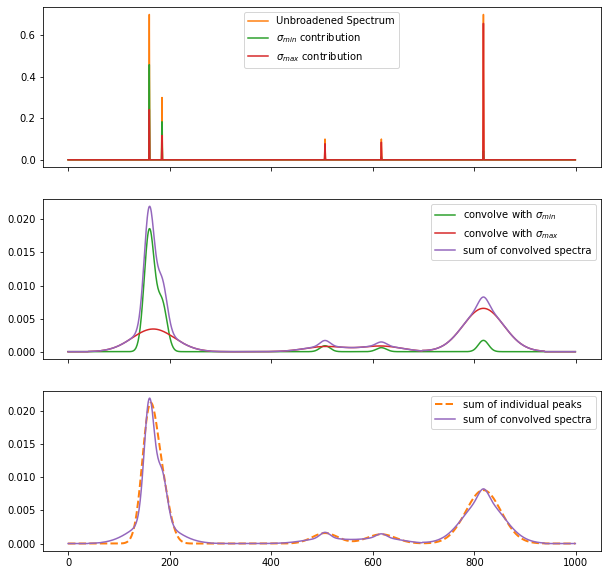

In [3]:
broaden_sigma_range(4)

To illustrate how the performance of the algorithm can vary, the above plots show the same unbroadened spectrum, but this time $\sigma$ ranges from 1 to 4, increasing along the x-axis. Calculting a kernel only for the minimum and maximum $\sigma$ and interpolating between them produces a broadened spectrum that is noticably different to exact implementation, summing over individual peaks.

In the above cases, only two kernels have been computed exactly, however in practice the number of kernels depends on the chosen sigma spacing and the range of sigma values. The below plot again shows the same unbroadened spectrum, broadened with three different choices of sigma spacing value, $\sqrt{2}$, 2 and 4. This time the sigma values are the same for each broadened spectra, but estimated using a different number of exactly computed kernels.

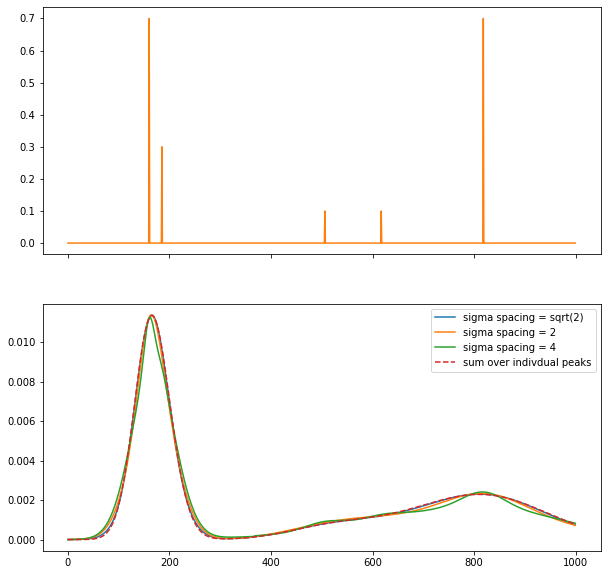

In [6]:
#multiple kernel case

sigma = np.linspace(1, 15, 1000)

def gaussian_eval(sigma, points, center):
        # calculate bin width, which is then used to normalize the Gaussian
        b_width = points[1] - points[0] 
        kernel = np.exp(-(points - center)**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))*b_width
        return kernel

def reference_method(data):
    kernels = gaussian_eval(sigma[:,np.newaxis], bin_mp, frequencies[:,np.newaxis])
    result_gauss = np.dot(kernels.transpose(), data)
    return result_gauss

def broaden_multiple_kernels(sigma, bins, points, frequencies, data, width_factor):

    def gaussian_mix(x, w1):
        #Return a linear combination of two Gaussians with weights
        return (w1 * gaussian(x, sigma=1)
                + (1-w1) * gaussian(x, sigma=width_factor))

    def find_coeffs(width_factor):
        sigma_values = np.linspace(1, width_factor, 10)
        x = np.linspace(-10, 50, 101)

        lower_mix = np.zeros(len(sigma_values))

        for i, s in enumerate(sigma_values):
            actual_gaussian = gaussian(x, s)
            mixl, _ = curve_fit(gaussian_mix, x, ydata=actual_gaussian, p0=[0.5],bounds=(0,1))

            mixl=mixl[0]
            lower_mix[i] = mixl

        coeffs = np.polyfit(sigma_values, lower_mix,3)
        return coeffs

    lower_coeffs = find_coeffs(width_factor)

    bin_width = bins[1]-bins[0]

    n_kernels = int(np.ceil(np.log(max(sigma)/min(sigma))/np.log(width_factor)))
    sigma_samples = width_factor**np.arange(n_kernels+1)*min(sigma)

    freq_range = 3*max(sigma)
    kernel_npts_oneside = np.ceil(freq_range/bin_width)

    kernels = gaussian_eval(sigma=sigma_samples[:, np.newaxis],
                            points=np.arange(-kernel_npts_oneside, kernel_npts_oneside+1, 1)*bin_width,
                            center=0)
    sigma_locations = np.searchsorted(sigma_samples, sigma)

    scaled_matrix = np.zeros((len(sigma), len(kernels)))
    for i in range(1, len(sigma_samples)):
        masked_block = (sigma_locations==i)
        sigma_factors = sigma[masked_block]/sigma_samples[i-1]

        lower_mix = np.polyval(lower_coeffs, sigma_factors)
        upper_mix = 1-lower_mix

        scaled_matrix[masked_block,i-1] += lower_mix*data[masked_block]
        scaled_matrix[masked_block,i] += upper_mix*data[masked_block]
    spectrum1 = np.sum([convolve(scaled_matrix[:,i], kernels[i], mode="same") for i in range(0,len(sigma_samples))],0)
    return spectrum1
    
spectrumr2 = broaden_multiple_kernels(sigma, bins, bin_mp, frequencies, y, np.sqrt(2))
spectrum2 = broaden_multiple_kernels(sigma, bins, bin_mp, frequencies, y, 2)
spectrum4 = broaden_multiple_kernels(sigma, bins, bin_mp, frequencies, y, 4)

fig, [ax1, ax2] = plt.subplots(nrows=2,
                               sharex=True,
                               gridspec_kw={
                               'height_ratios': [1, 1]})

ax1.plot(range(0,npts), y, 'C1', label='Unbroadened Spectrum')

ax2.plot(range(0,npts), spectrumr2, label='sigma spacing = sqrt(2)')
ax2.plot(range(0,npts), spectrum2, label='sigma spacing = 2')
ax2.plot(range(0,npts), spectrum4, label='sigma spacing = 4')
ax2.plot(range(0,npts), reference_method(y),'--', label='sum over indivdual peaks')
ax2.legend()

<ipython-input-5-65472df32e4b>:16: UserWarning: Unexpected values for mode gradients at 104834/221184 indices [(0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 2, 2), (0, 4, 0)]..., expected near-zero imaginary elements, got values of [1.35446214e-11 1.17571861e-11 3.01436341e-09 5.20717902e-11
 2.68514951e-12]..., compared to a max real value of 0.0015526250052521932. Data may have been lost when casting to real mode gradients
  modes, mode_grads = data.calculate_qpoint_phonon_modes(mp_grid(grid_spec), return_mode_gradients=True)
<ipython-input-4-a08a2821b4f5>:62: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  scaled_matrix[masked_block,i-1] += lower_mix*data[masked_block]
<ipython-input-4-a08a2821b4f5>:63: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  scaled_matrix[masked_block,i] += upper_mix*data[masked_block]


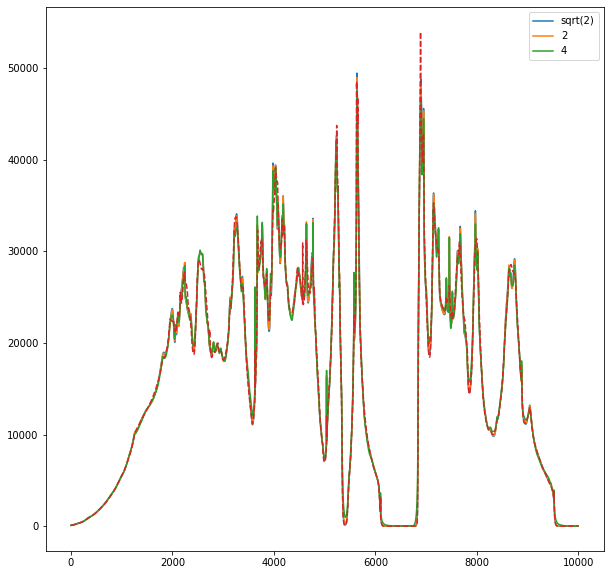

In [5]:
# use real data
from euphonic.cli.utils import (load_data_from_file, _grid_spec_from_args, _get_energy_bins)
from euphonic.util import mp_grid, mode_gradients_to_widths
from euphonic import ureg
from scipy.stats import norm

def import_real_data(filename, grid_space, energy_broadening):
    data = load_data_from_file(filename)

    recip_length_unit = ureg('1 /angstrom')
    grid_spec = _grid_spec_from_args(data.crystal, grid=None,
                                        grid_spacing=(grid_space
                                                    * recip_length_unit))

    # for adaptive broadening
    modes, mode_grads = data.calculate_qpoint_phonon_modes(mp_grid(grid_spec), return_mode_gradients=True)
    mode_widths = mode_gradients_to_widths(mode_grads, modes.crystal.cell_vectors)
    mode_widths *= energy_broadening

    modes.frequencies_unit = 'hartree'

    ebins = _get_energy_bins(modes, 10001)

    dos = modes._calculate_dos(ebins)
    sigma = mode_widths.to('hartree').magnitude
    bins = ebins.to('hartree').magnitude
    bin_mp = bins[:-1] + 0.5*np.diff(bins)
    freqs = modes.frequencies.magnitude

    return dos, sigma, bins, bin_mp, freqs

data_real, sigma_real, bins_real, bin_mp_real, frequencies_real = import_real_data('/home/jessfarmer/Broadening_Methods/Data/mp-147-20180417.yaml', 0.1, 1.5)
n_modes = frequencies_real.shape[-1]
weights = np.full(len(frequencies_real), 1/len(frequencies_real))

# get frequency values from bin centres
freqs = bin_mp_real

sigma_vals = np.zeros(len(freqs))
# get sigma values associated with frequencies
for i, f in enumerate(freqs):
    idx = (np.abs(np.ravel(frequencies_real)-f)).argmin()
    sigma_vals[i] = np.ravel(sigma_real)[idx]

# ensure no zero values to avoid divide by zero error
sigma_vals[sigma_vals == 0] = 10**-8

# evalulate gaussian function at each point - reference method
result_gauss = np.zeros(len(bin_mp_real))
for q in range(len(frequencies_real)):
    for m in range(n_modes):
        kernel = norm.pdf(bin_mp_real, loc=frequencies_real[q,m], scale=sigma_real[q,m])
        result_gauss += kernel*weights[q]

spectrum_r2 = broaden_multiple_kernels(sigma_vals, bins_real, bin_mp_real, freqs, data_real, np.sqrt(2))
spectrum_2 = broaden_multiple_kernels(sigma_vals, bins_real, bin_mp_real, freqs, data_real, 2)
spectrum_4 = broaden_multiple_kernels(sigma_vals, bins_real, bin_mp_real, freqs, data_real, 4)

plt.figure()
#plt.plot(data_real)
plt.plot(spectrum_r2, label='sqrt(2)')
plt.plot(spectrum_2, label='2')
plt.plot(spectrum_4, label='4')
plt.plot(result_gauss,'--')
plt.legend()
